In [1]:
from copy import deepcopy
import requests
import logging
from urllib.parse import quote
import constants
from dictor import dictor
from pathlib import Path
from PIL import Image
import dateutil
import datetime

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
logging.root.setLevel('INFO')
logging.debug('foo')

In [4]:
def get_coord(place=None):
    lat, lon = None, None
    if not place:
        print('lookup the lat/lon of city, town or geographic area')
        print('usage: paperpi -m met_no.get_coord "City, Area, Country"')
        print('paperpi -m met_no.get_coord "Golden Colorado, USA"')
        return (lat, lon)
    osm_endpoint = constants.osm_endpoint
    osm_query = constants.osm_query
    place_quote = quote(place)
    url = f'{osm_endpoint}{place_quote}{osm_query}'
    try:
        result = requests.get(url)
    except requests.RequestException as e:
        logging.warning(f'could not process request: {e}')
    if result.status_code == 200:
        if len(result.json()) > 0:
            lat = dictor(result.json()[0], 'lat')
            lon = dictor(result.json()[0], 'lon')
            display_name = dictor(result.json()[0], 'display_name')
            print(f'{display_name}\n{place}: {float(lat):.3f}, {float(lon):.3f}')
        else:
            print(f'no data was returned for place: {place}')
            print(f'check the spelling or try a more general query')
    else:
        print(f'No valid data was returned: status_code: {result.status_code}')
    
    return(lat, lon)    

In [17]:
def wind_barb(cache=None, windspeed_ms=None, direction=None):
    '''create a rotated wind barb for a given windspeed (m/s) and direction
    
    Args:
        cache(`str` or `Path`): path to store files
        windspeed_ms(`float`): windspeed in m/s
        direction(float): wind direction 0 North, 90 East, 180 S
        
    Returns:
        `pathlib.Path()`
    '''
    cache = Path(cache)
    logging.debug('calculating wind barb')
    if not cache:
        logging.warning('no cache available -- returning None')
        return None
    if not isinstance(windspeed_ms, (float, int)) or not isinstance(direction, (float, int)):
        logging.warning(f'TypeError, expected `int` or `float`: windspeed_ms: {type(windspeed_ms)}, direction: {type(direction)}')
        return None
    
    barb_imgs = [ i for i in Path(constants.wind_barbs_path).glob('*.png')]
    barb_imgs.sort()
    # wind barbs are graded in knots -- convert from m/s to knot
    windspeed_kt = convert_units(windspeed_ms, 'm/s', 'knot')
    # round direction to the nearest 5 degrees
    direction = 5 * round(direction/5)
    # windspeed under 1 knot use the null image
    if windspeed_kt < 1:
        img = barb_imgs[0]
    # windspeeds greater than 105 use the warning symbol
    elif windspeed_kt > 105:
        img = barb_imgs[-1]
    # else pull the appropriate item from the index
    else:
        # round up a little bit
        img = barb_imgs[int(windspeed_kt/5+0.5)+1]
        
    rotated_barb_file = Path(f'{img.stem}_{direction}.png')
    rotated_barb_file = cache/rotated_barb_file
    
    if rotated_barb_file.exists():
        logging.debug(f'using cached version at: {rotated_barb_file}')
    else:
        logging.debug(f'caching version at: {rotated_barb_file}')
        pil_img = Image.open(img)
        pil_img = pil_img.rotate(angle=direction, fillcolor='white')
        pil_img.save(fp=rotated_barb_file)
    return rotated_barb_file

In [6]:
# r = get_coord('Finnestadveien 45 4029 Stavanger Norway')

In [7]:
# def flatten_json(y, lookup={}):
#     '''flatten a json nested dictionary and add the value as a list 
#         lookup the orignial key in a lookup dict and add 
#         an the lookup value to the list of items
#         Courtesy of: https://stackoverflow.com/a/51379007/5530152
    
#     Args:
#         y(`dict`): nested json to flatten
#         lookup(`dict`): dictionary of keys and and values to append
        
#     Returns:
#         `dict`
        
#     Example:
#         y  = {'a': 100,
#               'b': 300,
#               'c': { 'cows':['annabell', 'sydney', 'monty'] }
#              }
#         lookup = {'a': 'mm',
#                   'b': 'moles',
#                   'cows': 'kg'}
                  
#         returns:
#             {'a': [100, 'mm'],
#              'b': [300, 'moles'],
#              'c_cows_000': ['annabell', 'kg'],
#              'c_cows_001': ['sydney', 'kg'],
#              'c_cows_002': ['monty', 'kg']}
#     '''
#     out = {}
    
#     def flatten(x, name='', unit=None):
#         if type(x) is dict:
#             for a in x:
#                 if a in lookup.keys():
#                     unit = lookup[a][0]
#                 flatten(x[a], f"{name}{a}_", unit)
#         elif type(x) is list:
#             i = 0
#             for a in x:
#                 flatten(a, f"{name}{i:03}_", unit)
#                 i += 1
#         else:
#             out[name[:-1]] = [x, unit]

#     flatten(y)
#     return out


In [8]:
def process_data(data, meta_data_flat, cache_path):
    
    def add_units(d):
        my_details = {}
        for my_detail, my_value in d.items():
            if my_detail in meta_data_flat.keys():
                my_details[my_detail] = (my_value, meta_data_flat[my_detail])
        
        return my_details
    
    cache_path = Path(cache_path)
    out = deepcopy(data)

    # move these into the constants?
    # hour keys to search for
    next_hours = ['next_1_hours', 'next_6_hours', 'next_12_hours']
    
    # wind related keys for adding windbarb
    wind_keys = set(['wind_from_direction', 'wind_speed'])
    
    
    # create a dict of all the symbol_code files with a dict comprehension
    symbol_dict = {i.stem: i for i in Path(constants.symbol_codes_path).glob("*")}
    
    # work through each time series
    for index, each_time in enumerate(out): 
        # convert zulu timedate string into human readable time
        time = dateutil.parser.isoparse(each_time['time'])
        time_string = time.replace(tzinfo=datetime.timezone.utc).astimezone(tz=None).strftime("%d %h %H:%M")
        out[index]['forecast_time_local'] = time_string
   
        # pull the details dict for processing
        this_details = dictor(each_time, 'data.instant.details')
         
        # add wind barbs
        if wind_keys.issubset(this_details.keys()):
            direction = this_details['wind_from_direction']
            wind_speed = this_details['wind_speed']
            this_details['wind_barb_image'] = wind_barb(cache=cache_path, direction=direction,
                                              windspeed_ms=wind_speed)
    
        # update the return dictionary
        out[index]['data']['instant']['details'].update(add_units(this_details))
        
        # process next_x_hours     
        for hour in next_hours:
            this_hour = dictor(each_time, f'data.{hour}')
            if this_hour:
                this_symbol = dictor(this_hour, 'summary.symbol_code')
                this_detail = dictor(this_hour, 'details')                    
                if this_symbol:
                    if this_symbol in symbol_dict.keys():
                        symbol_code_image = symbol_dict[this_symbol]
                    else:
                        symbol_code_image = None
                    this_hour['summary']['symbol_code_image'] = symbol_code_image
                    # update the dictionary
                    out[index]['data'][hour].update(this_hour)
                    
                # add units to detail for each hour if available, update the dictionary
                if this_detail:
                    out[index]['data'][hour]['details'].update(add_units(this_detail))
 
    return out   

In [9]:
def flatten_json(y):
    '''flatten a json nested dictionary and add the value as a list 
        lookup the orignial key in a lookup dict and add 
        an the lookup value to the list of items
        Courtesy of: https://stackoverflow.com/a/51379007/5530152
    
    Args:
        y(`dict`): nested json to flatten
        
    Returns:
        `dict`
        
    '''
    out = {}
    
    def flatten(x, name=''):
        if isinstance(x, dict):
#         if type(x) is dict:
            for a in x:
                flatten(x[a], f"{name}{a}_")
        elif isinstance(x, list):
#         elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, f"{name}{i:03}_")
                i += 1
        elif isinstance(x, tuple):
#         elif type(x) is tuple:
            out[name[:-1]] = x
        else:
            out[name[:-1]] = x

    flatten(y)
    return out


In [10]:
def convert_units(v, u_in, u_out, return_int=False):
    '''convert meterological units:
        known units:
            Temperature: celcius, farenheit, kelvin
            Velocity: m/s, k/h, m/h, knot
            length: mm, inch
    
    Args:
        v(`float`): value to convert
        u_in(`str`): input unit
        u_out(`str`): output unit
        
    Returns:
        `float`'''
    if not isinstance(v, (int, float)):
        logging.warning(f'TypeError: expected int or float: {v}')
        return v
    
    try:
        u_in = u_in.lower()
        u_out = u_out.lower()
    except AttributeError as e:
        logging.warning(f'unknown conversion: {u_in} to {u_out}')
        
    units = {
        'celsius': { 'celsius': v , 'fahrenheit': v*9/5+32, 'kelvin': v + 273.15},
        'fahrenheit': { 'celsius': (v-32)*5/9, 'fahrenheit': v, 'kelvin': (v-32)*5/9 + 273.15},
        'kelvin': { 'celsius': v-273.15, 'fahrenheit': (v - 273.15) * 9/5 + 32, 'kelvin': v},
        'm/s': {'m/s': v, 'k/h': v*3.6, 'm/h': v*2.237, 'knot': v*1.944},
        'k/h': {'m/s': v/3.6, 'k/h': v, 'm/h': v/1.609, 'knot': v/1.852},
        'm/h': {'m/s': v/2.237, 'k/h': v*1.609, 'm/h': v, 'knot': v*1.151},
        'knot': {'m/s': v/1.151, 'k/h': v*1.852, 'm/h': v/1.151, 'knot': v},
        'mm': {'inch': v/25.4},
        'inch': {'mm': v*25.4}
    }
    try:
        ret_val = units[u_in][u_out]
    except KeyError:
        logging.warning(f'unknown conversion: {u_in} to {u_out}')
        ret_val = v
    
    if return_int:
        try:
            ret_val = int(ret_val)
        except Exception:
            pass
        
    return ret_val

In [42]:
q = {'a': 8}

In [45]:
q.update(constants.text)

In [46]:
q

{'a': 8,
 't_precipitation': 'Precipitation',
 't_max': 'Max',
 't_min': 'Min',
 't_temperature': 'Temperature',
 't_wind': 'Wind',
 't_presure': 'Presure',
 't_humidity': 'Humidity',
 't_wind_direction': 'Wind Direction',
 't_uv_index': 'UV Index'}

In [47]:
def post_process(data, self):
    '''convert tuples containing value/unit pairs into strings and convert units where needed 
    and add text, time and location strings
    
    Args:
        data(`dict`): flat dictionary containing key: (value, unit)
    
    Returns:
        `dict`'''
    
    out = {}
    
    # map configuration options to unit conversion dictionary
    unit_dict = {'celsius': self.config['temp_units'].lower(), 
                 'mm': self.config['rain_units'.lower()],
                 'm/s': self.config['windspeed'].lower()}
    
    out.update(constants.text)
    out['time_updated_iso_zulu'] = datetime.datetime.utcnow().isoformat()[:-3] + 'Z'
    out['time_updated_iso_local'] = datetime.datetime.now().isoformat()[:-3]
    out['time_updated_local'] = datetime.datetime.now().strftime('Updated: %d %b, %H:%M')
    out['forecast_location'] = self.config['location_name']
        
    for k, v in data.items():
        if isinstance(v, tuple) and len(v) > 1:
            if v[1] in unit_dict:
                my_unit = unit_dict[v[1]]
                value = convert_units(v[0], v[1], my_unit, True)
            else:
                my_unit = v[1]
                value = v[0]
                
            if my_unit in constants.abreviations:
                abreviation = constants.abreviations[my_unit]
            else:
                abreviation = my_unit
           
        else:
            value = v
            abreviation = ''
        
        if isinstance(value, float):
            value = int(value)
        
        clean_str = f'{value}{abreviation}'
            
            
        
        out[k] = clean_str
    return out
    

In [48]:
def update_function(self):
    is_updated = False
    # build out some sample data in the constants file
    data = {}
    priority = 2**15
    
    failure = (is_updated, data, priority)
    
    required_config_options = {'lat': 47.94, 
                               'lon': 106.966, 
                               'location_name': 'Ulaanbaatar, Mongolia',
                               'temp_units': 'celsius',
                               'rain_units': 'mm', 
                               'windspeed': 'm/s'
                              }
    
    for k, v in required_config_options.items():
        if not k in self.config:
            logging.info(f'missing configuration value: {k}')
            logging.info(f'using default value: {v}')
            self.config[k] = v
    
    try:
        forecast = requests.get(f"{constants.yr_endpoint}lat={self.config['lat']}&lon={self.config['lon']}")
    except RequestException as e:
        logging.warning(e)
        return failure
    
    if forecast.status_code == 200:
        if dictor(forecast.json(), 'properties.meta.updated_at'):
            is_updated = True
            priority = self.max_priority
            data = forecast.json()
        else:
            logging.warning(f'incomplete data returned; no forecast available')
    else:
        logging.warning(f'failed to fetch data from {constants.yr_endpoint}: status_code: {forecast.status_code}')
        
    meta_data = dictor(data, 'properties.meta.units')
    timeseries_data = dictor(data, 'properties.timeseries')

    # flatten the meta_data JSON so it can be used in processing the rest of the data
    if meta_data and timeseries_data:
        # flatten the meta_data JSON so it can be used in processing the rest of the data
        meta_data_flat = flatten_json(meta_data)
        timeseries_data = process_data(timeseries_data, meta_data_flat, self.cache.path)
    else:
        return failure
    
    data = timeseries_data    
    data = flatten_json(timeseries_data)
    data = post_process(data, self)
    
    return is_updated, data, priority

In [49]:
get_coord('Ulaanbaatar, mongolia')

Улаанбаатар, Монгол Улс
Ulaanbaatar, mongolia: 47.950, 106.967


('47.949809', '106.96672419388133')

In [50]:
coord = get_coord('Den Haag, Netherlands')
self = SelfDummy()
self.config = {'lat': coord[0], 
               'lon': coord[1], 
               'location_name': 'Den Haag',
               'temp_units': 'fahrenheit',
               'rain_units': 'inch', 
               'windspeed': 'm/h'}
self.cache = CacheFiles()

Den Haag, Zuid-Holland, Nederland
Den Haag, Netherlands: 52.080, 4.311


In [51]:
is_updated, data, priority = update_function(self)

{'t_precipitation': 'Precipitation', 't_max': 'Max', 't_min': 'Min', 't_temperature': 'Temperature', 't_wind': 'Wind', 't_presure': 'Presure', 't_humidity': 'Humidity', 't_wind_direction': 'Wind Direction', 't_uv_index': 'UV Index', 'time_updated_iso_zulu': '2020-11-09T19:57:56.894Z', 'time_updated_iso_local': '2020-11-09T20:57:56.894', 'time_updated_local': 'Updated: 09 Nov, 20:57', 'forecast_location': 'Den Haag'}


In [52]:
data

{'t_precipitation': 'Precipitation',
 't_max': 'Max',
 't_min': 'Min',
 't_temperature': 'Temperature',
 't_wind': 'Wind',
 't_presure': 'Presure',
 't_humidity': 'Humidity',
 't_wind_direction': 'Wind Direction',
 't_uv_index': 'UV Index',
 'time_updated_iso_zulu': '2020-11-09T19:57:56.894Z',
 'time_updated_iso_local': '2020-11-09T20:57:56.894',
 'time_updated_local': 'Updated: 09 Nov, 20:57',
 'forecast_location': 'Den Haag',
 '000_time': '2020-11-09T19:00:00Z',
 '000_data_instant_details_air_pressure_at_sea_level': '1023hPa',
 '000_data_instant_details_air_temperature': '51F',
 '000_data_instant_details_cloud_area_fraction': '86%',
 '000_data_instant_details_cloud_area_fraction_high': '86%',
 '000_data_instant_details_cloud_area_fraction_low': '0%',
 '000_data_instant_details_cloud_area_fraction_medium': '0%',
 '000_data_instant_details_dew_point_temperature': '50F',
 '000_data_instant_details_fog_area_fraction': '0%',
 '000_data_instant_details_relative_humidity': '94%',
 '000_data

In [ ]:
forecast = requests.get(f"{constants.yr_endpoint}lat={self.config['lat']}&lon={self.config['lon']}")

In [ ]:
forecast.json()

In [ ]:
# def prepare_data(meta_flat, data_flat):
#     '''prepare flat data for use by Layout() object by appending 
#         image paths and converting float/ints into strings with appropriate
#         units
        
#     Args: 
#         meta_flat(`dict`): flattened meta_data from meteo.no
#         data_flat(`dict`): flattened timeseries data meteo.no
        
#     Returns:
#         `dict` flattened dict of all timeseries data with a path to the symbol_code file, 
#         formatted wind barb image path, 
#         float/ints converted to strings with appropriate units or values attached
#     '''
#     # dict comprehension of all available symbol_code images
# #     img_dict = {i.stem: i for i in Path(constants.symbol_codes_path).glob("*")}
#     out = {}
    
#     for key in data_flat:
#         value = data_flat[key]
        
#         # add path to symbol_code entries
#         if 'symbol_code' in key:
#             if value[0] in img_dict.keys():
#                 out[f'{key}_image'] = img_dict[value[0]].resolve()
        
#         # gather all the wind information
# #         if 'wind' in key:
# #             wind_keys.append(key)
        
#         # unit conversion could happen here

        
#         # convert float/int to string and add units
#         if len(value) >= 2:
#             if value[1] in constants.abreviations.keys():
#                 unit = abreviations[value[1]]
#             else:
#                 unit = value[1]
#             val_unit = f'{value[0]}{unit}'
#         else:
#             val_unit = value[0]
        
#         out[key] = val_unit
#         wind_keys.sort()
#     return out, wind_keys

In [14]:
!ln ../../library/SelfDummy.py ./
!ln ../../library/CacheFiles.py ./
from SelfDummy import SelfDummy
from CacheFiles import CacheFiles


ln: failed to create hard link './SelfDummy.py': File exists
ln: failed to create hard link './CacheFiles.py': File exists


In [61]:
from epdlib import Layout

In [62]:
import os
dir_path = os.path.dirname(os.path.realpath(__file__))

NameError: name '__file__' is not defined

In [103]:
m = Layout(resolution=(800, 480))

In [151]:
logging.root.setLevel('INFO')

In [159]:
layout = {
    '000_data_next_1_hours_summary_symbol_code_image': {
        'image': True,
        'width': 1/5,
        'height': 1/5,
        'abs_coordinates': (0, 0),
        'relative': False,
    }
}

In [234]:
layout = {
    '000_forecast_time_local': {
        'image': None,
        'inverse': True,
        'padding': 0,
        'width': 1/3,
        'height': 1/12,
        'abs_coordinates': (0, 0),
        'hcenter': False,
        'vcenter': True,
        'relative': False,
        'max_lines': 1,
        'font': '../../fonts/ABeeZee/ABeeZee-Regular.ttf'
    },
    '000_data_next_1_hours_summary_symbol_code_image': {
          'image': True,
          'hcenter': True,
          'vcenter': True,
          'height': 1/3,
          'width': 1/3,
          'abs_coordinates': [0, None],
          'relative': ['000_data_next_1_hours_summary_symbol_code_image', '000_forecast_time_local'],
    },
    '000_data_instant_details_wind_barb_image': {
          'image': True,
          'hcenter': True,
          'vcenter': True,
          'width': 1/6,
          'height': 1/6,
          'abs_coordinates': [0, None],
          'relative': ['000_data_instant_details_wind_barb_image', '000_data_next_1_hours_summary_symbol_code_image'],
    },
    '000_data_instant_details_wind_speed': {
          'image': False,
          'inverse': True,
          'hcenter': True,
          'vcenter': True,
          'width': 1/6,
          'height': 1/6,
          'abs_coordinates': [None, None],
          'relative': ['000_data_instant_details_wind_barb_image', '000_data_next_1_hours_summary_symbol_code_image'],
          'font': '../../fonts/ABeeZee/ABeeZee-Regular.ttf'
    },
    '000_data_instant_details_air_temperature': {
        'image': None,
        'max_lines': 1,
        'padding': 0,
        'width': 1/3,
        'height': 1/6,
        'abs_coordinates': [0, None],
        'hcenter': True,
        'vcenter': True,
        'relative': ['000_data_instant_details_air_temperature', '000_data_instant_details_wind_barb_image'],
        'font': '../../fonts/ABeeZee/ABeeZee-Regular.ttf'
    },
    ''
    
#     '000_data_next_1_hours_summary_symbol_code_image': {
#         'image': True,
#         'padding': 0,
#         'width': 1/6,
#         'height:': 1/3,
#         'abs_coordinates': [0, None],
#         'hcenter': True,
#         'vcenter': True,
#         'relative': ['000_data_next_1_hours_summary_symbol_code_image', '000_forecast_time_local']
#     },
#     '000_data_instant_details_air_temperature': {
#         'image': None,
#         'padding': 0,
#         'width': 1/3,
#         'height': 1/3,
#         'abs_coordinates': [0, None],
#         'hcenter': True,
#         'vcenter': True,
#         'relative': ['000_data_instant_details_air_temperature', '000_data_next_1_hours_summary_symbol_code_image'],
#         'font': '../../fonts/ABeeZee/ABeeZee-Regular.ttf'
#     },
#     '000_data_next_1_hours_details_precipitation_amount': {
#         'image': None,
#         'padding': 0,
#         'width': 1/3,
#         'height': 3/12,
#         'abs_coordinates': [0, None],
#         'hcenter': True,
#         'vcenter': True,
#         'relative': ['000_data_next_1_hours_details_precipitation_amount', '000_data_instant_details_air_temperature'],
#         'font': '../../fonts/ABeeZee/ABeeZee-Regular.ttf'
#     }

}

In [235]:
m.layout = layout

INFO:root:set text block: 000_forecast_time_local
INFO:root:TextBlock created
INFO:root:set image block 000_data_next_1_hours_summary_symbol_code_image
INFO:root:Image Block Created
INFO:root:set image block 000_data_instant_details_wind_barb_image
INFO:root:Image Block Created
INFO:root:set text block: 000_data_instant_details_wind_speed
INFO:root:TextBlock created
INFO:root:set text block: 000_data_instant_details_air_temperature
INFO:root:TextBlock created


In [236]:
m.update_contents(data)

INFO:root:updating blocks


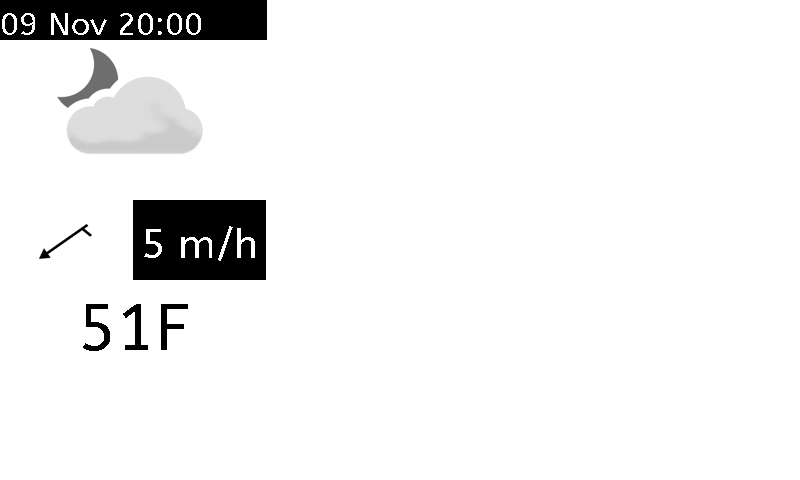

In [237]:
m.concat()

In [53]:
data

{'t_precipitation': 'Precipitation',
 't_max': 'Max',
 't_min': 'Min',
 't_temperature': 'Temperature',
 't_wind': 'Wind',
 't_presure': 'Presure',
 't_humidity': 'Humidity',
 't_wind_direction': 'Wind Direction',
 't_uv_index': 'UV Index',
 'time_updated_iso_zulu': '2020-11-09T19:57:56.894Z',
 'time_updated_iso_local': '2020-11-09T20:57:56.894',
 'time_updated_local': 'Updated: 09 Nov, 20:57',
 'forecast_location': 'Den Haag',
 '000_time': '2020-11-09T19:00:00Z',
 '000_data_instant_details_air_pressure_at_sea_level': '1023hPa',
 '000_data_instant_details_air_temperature': '51F',
 '000_data_instant_details_cloud_area_fraction': '86%',
 '000_data_instant_details_cloud_area_fraction_high': '86%',
 '000_data_instant_details_cloud_area_fraction_low': '0%',
 '000_data_instant_details_cloud_area_fraction_medium': '0%',
 '000_data_instant_details_dew_point_temperature': '50F',
 '000_data_instant_details_fog_area_fraction': '0%',
 '000_data_instant_details_relative_humidity': '94%',
 '000_data